In [1]:
%load_ext watermark

In [2]:
%watermark -p scikit-learn,mapie,numpy

scikit-learn: 1.6.1
mapie       : 1.2.0
numpy       : 2.0.2



## Define a Dataset

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


iris = load_iris()
X = iris.data
y = iris.target

X_, X_test, y_, y_test = train_test_split(
    X, y, test_size=0.015, random_state=123, stratify=y)
    
# make training and calibration dataset
X_train, X_calib, y_train, y_calib = train_test_split(
    X_, y_, test_size=0.5, random_state=123, stratify=y_)

## Train a Model

In [4]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=123, solver="newton-cg")

model.fit(X_train, y_train);

## Get Predictions

In [5]:
pred = model.predict_proba(X_calib)

# predictions have the shape [n_samples, n_classes]
pred.shape

(74, 3)

In [6]:
# each entry has 3 probability scores here, 1 for each class
pred[0] # first prediction

array([3.58462019e-06, 2.06334253e-02, 9.79362990e-01])

# Conformal Prediction From Scratch

#### Compute quantile threshold

In [7]:
confidence_level = 0.95

In [8]:
import numpy as np


# Select the probabilities corresponding to the true class labels

proba_true = pred[np.arange(y_calib.shape[0]), y_calib]
print(proba_true.shape)

(74,)


In [9]:
# Compute nonconformity score

nc_scores = 1 - proba_true

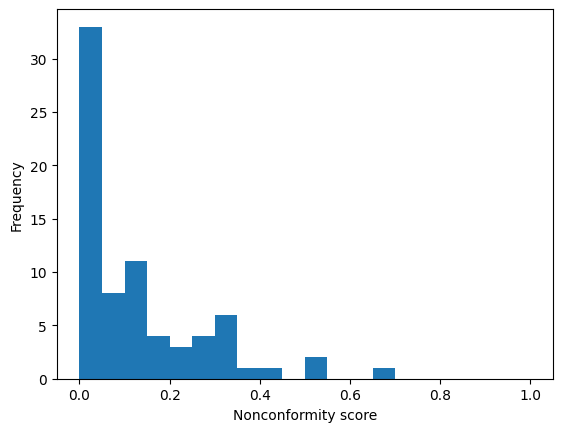

In [10]:
import matplotlib.pyplot as plt

plt.hist(nc_scores, bins=20, range=[0, 1])
plt.xlabel("Nonconformity score")
plt.ylabel("Frequency")
plt.show()

In [11]:
# apply finite sample correction

n = y_calib.shape[0]

q_level = np.ceil((n+1)*(confidence_level))/n
q_level

np.float64(0.972972972972973)

In [12]:
# select the threshold such that 95% of the cases
# are included (fall below)

thres = np.quantile(nc_scores, q_level, method="higher")
thres

np.float64(0.5476846456583164)

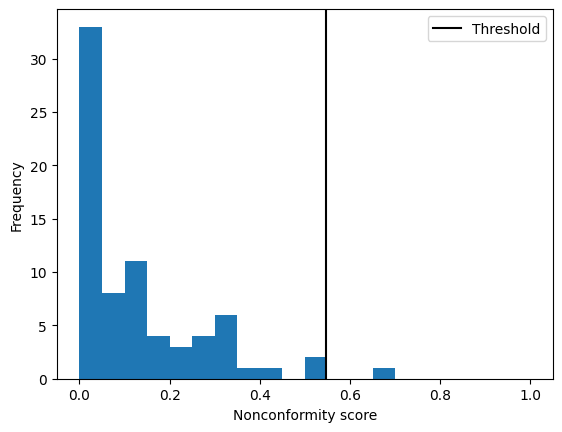

In [13]:
import matplotlib.pyplot as plt

plt.hist(nc_scores, bins=20, range=[0, 1])
plt.axvline(thres, color="black", label="Threshold")
plt.xlabel("Nonconformity score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Compute predictions sets for new data

In [14]:
test_nc_scores = 1 - model.predict_proba(X_test)

prediction_sets = test_nc_scores <= thres

prediction_sets

array([[False,  True,  True],
       [ True, False, False],
       [False, False,  True]])

In [15]:
class_names = np.array(["Setosa", "Versicolor", "Virginica"])

for row in prediction_sets:
    print(class_names[row])

['Versicolor' 'Virginica']
['Setosa']
['Virginica']


# Conformal Prediction Using MAPIE

- MAPIE documentation: https://mapie.readthedocs.io/
- Code is inspired by Christoph Molnar's ["Conformal Prediction" book](https://christophmolnar.com/books/conformal-prediction/)

In [16]:
from mapie.classification import SplitConformalClassifier

cp = SplitConformalClassifier(estimator=model, prefit=True, conformity_score="lac", confidence_level=0.95)
cp.conformalize(X_calib, y_calib)
y_pred, y_set = cp.predict_set(X_test)

In [17]:
y_pred, y_set = cp.predict_set(X_test)
y_set = np.squeeze(y_set)
y_set

array([[False,  True,  True],
       [ True, False, False],
       [False, False,  True]])

In [18]:
for row in y_set:
    print(class_names[row])

['Versicolor' 'Virginica']
['Setosa']
['Virginica']
